# Mutual Information Estimation

$\def\abs#1{\left\lvert #1 \right\rvert}
\def\Set#1{\left\{ #1 \right\}}
\def\mc#1{\mathcal{#1}}
\def\M#1{\boldsymbol{#1}}
\def\R#1{\mathsf{#1}}
\def\RM#1{\boldsymbol{\mathsf{#1}}}
\def\op#1{\operatorname{#1}}
\def\E{\op{E}}
\def\d{\mathrm{\mathstrut d}}$

In [1]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython import display

%matplotlib inline

## Problem formulations

**How to formulate the problem of mutual information estimation?**

The problem of estimating the mutual information is:

---
Given $n$ samples

$$(\R{X}_1,\R{Y}_1),\dots, (\R{X}_n,\R{Y}_n) \stackrel{iid}{\sim} P_{\R{X},\R{Y}}\in \mc{P}(\mc{X},\mc{Y})$$ 

i.i.d. drawn from an *unknown* probability measure $P_{\R{X},\R{Y}}$ from the space $\mc{X}\times \mc{Y}$, estimate the *mutual information (MI)*

$$
\begin{align}
I(\R{X}\wedge\R{Y}) &:= E\left[\log \frac{d P_{\R{X},\R{Y}}(\R{X},\R{Y})}{d (P_{\R{X}} \times P_{\R{Y}})(\R{X},\R{Y})} \right].
\end{align}
$$ (MI)

---

---

**Exercise** Run the following code cell a couple of times to see different distributions of samples of $(\R{X},\R{Y})$. What is unknown about the sampling distribution?

,X,Y
0,-1.445809,-1.409285
1,1.078703,0.094753
2,-1.571241,-1.787619
3,0.226019,-1.083342
4,0.634962,0.639702
...,...,...
95,-0.028877,0.248850
96,0.366130,0.905034
97,-0.476919,-0.509006
98,1.623603,1.203374


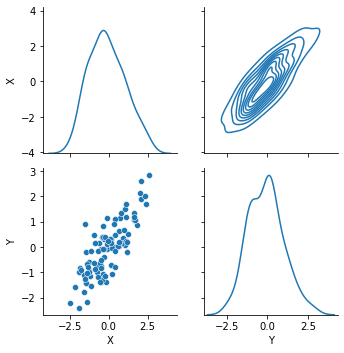

In [2]:
# Sampling from an unknown probability measure
rho = 0.8 - 0.19 * np.random.rand()
mean, cov, n = [0, 0], [[1, rho], [rho, 1]], 100
rng = np.random.default_rng()
XY = rng.multivariate_normal(mean, cov, n)

# Show the samples
data = pd.DataFrame(XY, columns=["X", "Y"])
display.display(data)

# Plot the samples
def plot_samples_with_kde(data, **kwargs):
    p = sns.PairGrid(data, **kwargs)
    p.map_lower(sns.scatterplot)  # scatter plot of samples
    p.map_upper(sns.kdeplot)  # kernel density estimate for pXY
    p.map_diag(sns.kdeplot)  # kde for pX and pY
    return p


p = plot_samples_with_kde(data)
plt.show()

The density is

$$
\frac{d P_{\R{X},\R{Y}}}{dxdy} = \mc{N}_{\M{0},\left[\begin{smallmatrix}1 & \rho \\ \rho & 1\end{smallmatrix}\right]}(x,y)
$$

but $\rho$ is unknown (uniformly random over $[0.8,0.99)$).

---

**Can we generalize the problem further?**

Estimating MI may be viewed as a special case of the following problem:

---

Estimate the KL *divergence*

$$
\begin{align}
D(P_{\R{Z}}\|P_{\R{Z}'}) &:= E\left[\log \frac{d P_{\R{Z}}(\R{Z})}{d P_{\R{Z}'}(\R{Z})} \right]
\end{align}
$$ (D)

using 
- a sequence $\R{Z}^n:=(\R{Z}_1,\dots, \R{Z}_n)\sim P_{\R{Z}}^n$ of i.i.d. samples from $P_{\R{Z}}$ if $P_{\R{Z}}$ is unknown, and
- another sequence ${\R{Z}'}^{n'}\sim P_{\R{Z}'}^{n'}$ of i.i.d. samples from $P_{\R{Z}'}$  if $P_{\R{Z}'}$, the *reference measure* of $P_{\R{Z}}$, is also unknown.

---

---
**Exercise** 

Although $\R{X}^n$ and $\R{Y}^n$ for MI estimation should have the same length, $\R{Z}^n$ and ${\R{Z}'}^{n'}$ can have different lengths, i.e., $n \not\equiv n'$. Why?

**Solution** The dependency between $\R{Z}$ and $\R{Z}'$ does not affect the divergence.

---

Regarding the mutual information as a divergence from joint to product distributions, the problem can be further generalized to estimtate other divergences such as the $f$-divergence:

For a strictly convex function $f$ with $f(1)=0$,

$$
\begin{align}
D_f(P_{\R{Z}}\|P_{\R{Z}'}) &:= E\left[ f\left(\frac{d P_{\R{Z}}(\R{Z}')}{d P_{\R{Z}'}(\R{Z}')}\right) \right].
\end{align}
$$ (f-D)

$f$-divergence in {eq}`f-D` reduces to KL divergence when $f=u \log u$:

$$
\begin{align}
E\left[ \frac{d P_{\R{Z}}(\R{Z}')}{d P_{\R{Z}'}(\R{Z}')} \log \frac{d P_{\R{Z}}(\R{Z}')}{d P_{\R{Z}'}(\R{Z}')}  \right] &= \int_{\mc{Z}} \color{gray}{d P_{\R{Z}'}(z)} \cdot \frac{d P_{\R{Z}}(z)}{\color{gray}{d P_{\R{Z}'}(z)}} \log \frac{d P_{\R{Z}}(z)}{d P_{\R{Z}'}(z)}. 
\end{align}
$$

---

**Exercise**

Show that $D_f(P_{\R{Z}}\|P_{\R{Z}'})\geq 0$ with equality iff $P_{\R{Z}}=P_{\R{Z}'}$ using Jensen's inequality and the properties of $f$.

**Solution**

It is a valid divergence because, by Jensen's inequality,

$$
D_f(P_{\R{Z}}\|P_{\R{Z}'}) \geq  f\bigg( \underbrace{E\left[ \frac{d P_{\R{Z}}(\R{Z}')}{d P_{\R{Z}'}(\R{Z}')} \right]}_{=1}\bigg) = 0
$$

with equality iff $P_{\R{Z}}=P_{\R{Z}'}$.

---

Regarding the divergence as an expectation, it is approximated by the sample average:

$$
\begin{align}
D_f(P_{\R{Z}}\|P_{\R{Z}'}) &\approx 
\frac1n \sum_{i\in [n]} f\left(\frac{d P_{\R{Z}}(\R{Z}'_i)}{d P_{\R{Z}'}(\R{Z}'_i)}\right).
\end{align}
$$ (avg-f-D)

However, this is not a valid estimate because it involves the unknown measures $P_{\R{Z}}$ and $P_{\R{Z}'}$.

One may further estimate the *density ratio*

$$
\begin{align}
z \mapsto \frac{d P_{\R{Z}}(z)}{d P_{\R{Z}'}(z)}
\end{align}
$$ (dP-ratio)

or estimate the density defined respective to some reference measure $\mu$:

$$
\begin{align}
p_{\R{Z}}&:=\frac{dP_{\R{Z}}}{d\mu} \in \mc{P}_{\mu}(\mc{Z}).
\end{align}
$$ (density)

## Neural estimation of KL divergence

Estimating MI well neither require nor imply the divergence/density to be estimated well. However, MI estimation is often not the end goal, but an objective to train a neural network to return the divergence/density. The features/representations learned by the neural network may be applicable to different downstream inference tasks.

### With known reference

To explain the idea of neural estimation, consider the problem of estimating the KL divergence with a known reference, i.e., $P_{\R{Z}}$ is unknown but $P_{\R{Z}'}$ is known.

---
**Proposition**

$$
\begin{align}
D(P_{\R{Z}}\|P_{\R{Z}'}) & =  \sup_{Q\in \mc{P}(\mc{Z})} E \left[ \log \frac{dQ(\R{Z})}{dP_{\R{Z}'}(\R{Z})} \right] 
\end{align}
$$ (D1)

where the optimal solution is $Q=P_{\R{Z}}$.

---

It is easy to check that the optimal solution gives the KL divergence formula in {eq}`D`. The proposition essentially gives a tight lower bound on KL divergence maximized by the unknown distribution.

---

**Proof**

To prove {eq}`D1`,

$$
\begin{align*}
D(P_{\R{Z}}\|P_{\R{Z}'})  &= D(P_{\R{Z}}\|P_{\R{Z}'}) - \inf_{Q\in \mc{P}(\mc{Z})} \underbrace{D(P_{\R{Z}}\|Q)}_{\geq 0 \text{ with equality iff } Q=P_{\R{Z}}\kern-3em} \\
&= \sup_{Q\in \mc{P}(\mc{Z})}  \underbrace{D(P_{\R{Z}}\|P_{\R{Z}'})}_{=E \left[\frac{dP_{\R{Z}}(\R{Z})}{dP_{\R{Z}'}(\R{Z})}\right]} -  \underbrace{D(P_{\R{Z}}\|Q)}_{=E \left[\frac{dP_{\R{Z}}(\R{Z})}{dQ(\R{Z})}\right]}\\
&= \sup_{Q\in \mc{P}(\mc{Z})} E \left[\frac{dQ(\R{Z})}{dP_{\R{Z}'}(\R{Z})}\right]
\end{align*}
$$

---

The idea of neural estimation is to 

- estimate the expectation in {eq}`D1` by the sample average  

$$
\frac1n \sum_{i\in [n]} \log \underbrace{\frac{dQ(\R{Z}_i)}{dP_{\R{Z}'}(\R{Z}_i)}}_{\text{(*)}},
$$

- use a neural network to compute the density ratio (*), and train the network to maximizes the expectation, e.g., by gradient ascent on the above sample average.

Since both $P_{\R{Z}'}$ and $Q$ are known, the sample average above is a valid estimation of the divergence.

**But how to use a neural network to compute the density ratio?**

KL divergence is related to the entropy and cross entropy:

$$
\begin{align}
D(P_{\R{Z}}\| P_{\R{Z}'})= \overbrace{\underbrace{E\left[-\log p_{\R{Z}'}(\R{Z})\right]}_{\approx \frac1n \sum_{i\in [n]} \log p_{\R{Z}'}(\R{Z}_i)}}^{\text{cross entropy}} - \overbrace{\underbrace{H(\R{Z})}_{:= E\left[ \log \frac{1}{p_{\R{Z}}(\R{Z})}\right]}}^{\text{entropy}}
\end{align}
$$ (D->H)

Cross entropy can be approximated by the sample average above since $p_{\R{Z}'}$ is known.
In otherwise, KL divergence can be estimated using an entropy estimate.

**How to estimate the entropy?**

Substituting {eq}`D->H` into {eq}`D1` gives:

---

**Corollary** 

$$
\begin{align}
H(\R{Z}) = \inf_{q\in \mc{P}_{\mu}(\mc{Z})} E\left[- \log q(\R{Z})\right]
\end{align}
$$ (H1)

where the optimal $q$ satisfies $q(\R{Z})=p_{\R{Z}}(\R{Z})$ in {eq}`density` almost surely.


---

Suppose $\R{Z}$ is discrete. We can apply the following change of variable to {eq}`H1` that

$$
q(z) = \frac{e^{t_z}}{\sum_{z\in \mc{Z}} e^{t_z}} \quad \text{for }z\in \mc{Z},
$$ (q->t_z)

called the *soft-max* layer, and optimize a neural network that takes no input but returns a vector 

$$\M{t}:=\begin{bmatrix} t_z\end{bmatrix}_{z\in \mc{Z}} \in \mathbb{R}^{\mc{Z}},$$

called the *logits*.

![Discrete](nn_discrete.dio.svg)

**What if $\R{Z}$ is continuous?**

We can apply the following change of variable instead

$$
q(z) := \frac{e^{t(z)}}{ \underbrace{\int_{\mc{Z}} e^t\,d\mu}_{c:=} } \quad \text{for }z\in \op{supp}(p_{\R{Z}}):=\Set{z\in \mc{Z}\mid p_{\R{Z}}>0}.
$$ (q->t:1)

which must be in $\mc{P}_{\mu}(\mc{Z})$ for all real-valued function $t:\mc{Z}\to \mathbb{R}$.  
In particular, since $e^{t(z)}>0$, $z$ has to be restricted to the support $\op{supp}(p_{\R{Z}})$ of $p_{\R{Z}}$.

The neural network can take input $z$ and returns output $t(z)$.

**But how to compute the normalization factor $c$ in {eq}`q->t:1`?**

We can apply importance sampling. 

Consider any distribution $P_{\R{Z}''}\in \mc{P}(\mc{Z})$ such that

$$P_{\R{Z}''}\succeq P_{\R{Z}},$$

which means that any event $\mc{Z}$ is probable w.r.t. $P_{\R{Z}}$ is also probable w.r.t. $P_{\R{Z}''}$, or equivalently,

$$
\op{supp}(p_{\R{Z}''})\supseteq \op{supp}(p_{\R{Z}}).
$$  (Porder)

The desired integral can then be turned into an expectation:

$$
\begin{align}
\int_{\mc{Z}} e^t\,d\mu &= \int_{\mc{Z}} \frac{e^t}{p_{\R{Z}''}} p_{\R{Z}''}\,d\mu \\
& = E\left[ \frac{e^{t(\R{Z}'')}}{p_{\R{Z}''}(\R{Z}'')} \right].
\end{align}
$$ (int->avg)

---
**Proposition** 

For any $P_{\R{Z}''}\succeq P_{\R{Z}}$ {eq}`Porder`,

$$
\begin{align}
H(\R{Z}) &=  - \sup_{t: \mc{Z} \to \mathbb{R}} E[t(\R{Z})] + \log E\left[ \frac{e^{t(\R{Z}'')}}{p_{\R{Z}''}(\R{Z}'')} \right]
\end{align}
$$ (H2)

where the optimal $t$ satisfies $t(\R{Z}) = \log p_{\R{Z}}(\R{Z}) + c$
almost surely for some constant $c\in \mathbb{R}$.

---

In summary, applying {eq}`H2` to {eq}`D->H` gives the following divergence estimate:

---
**Corollary** 

For any $P_{\R{Z}''}\succeq P_{\R{Z}}$ {eq}`Porder`,

$$
\begin{align}
D(P_{\R{Z}}\|P_{\R{Z}'}) &= \underbrace{E\left[-\log p_{\R{Z}'}(\R{Z})\right]}_{\approx \frac{1}{n} \sum_{i\in [n]} -\log p_{\R{Z}'}(\R{Z}_i) } +  \overbrace{\sup_{t: \mc{Z} \to \mathbb{R}} \underbrace{E[t(\R{Z})]}_{\approx \frac1{n} \sum_{i\in [n]} t(\R{Z}_i)} - \log \underbrace{E\left[ \frac{e^{t(\R{Z}'')}}{p_{\R{Z}''}(\R{Z}'')} \right]}_{\color{blue}{\frac1{n''} \sum_{i\in [n'']} \frac{e^{t(\R{Z}''_i)}}{p_{\R{Z}''}(\R{Z}''_i)}}}}^{H(\R{Z})=}
\end{align}
$$ (D2)

for i.i.d. samples $\R{Z}^n$ and ${\R{Z}''}^{n''}$ of $\R{Z}$ and $\R{Z}''$ respectively. The optimal $t$ satisfies $t(\R{Z}) = \log p_{\R{Z}}(\R{Z}) + c$
almost surely for some constant $c\in \mathbb{R}$.

---

Since the divergence does not depend on $P_{\R{Z}''}$, we can further optimize it to reduce the variance of the final sample average highlighted in blue.

---

**Exercise** Show that the optimal choice of $P_{\R{Z}''}$ that minimizes the variance of 

$$\frac1{n''} \sum_{i\in [n'']} \frac{e^{t(\R{Z}''_i)}}{p_{\R{Z}''}(\R{Z}''_i)}$$ 

has $p_{\R{Z}''}=e^t/c$ for some constant $c$.

**Proof**

With $p_{\R{Z}''}=e^t/c$,

$$
\begin{align}
\frac1{n''} \sum_{i\in [n'']} \frac{e^{t(\R{Z}''_i)}}{\underbrace{p_{\R{Z}''}(\R{Z}''_i)}_{=e^{t(\R{Z}'')}/c}} &= \frac1{n''} \sum_{i\in [n'']} c = c
\end{align}
$$ 

which has $0$ variance since $c$ is a constant. Hence, the variance is minimized as desired.

---

In practice, such a choice is impractical because:

- The constant $c$ used in defining the optimal $p_{\R{Z}''}$ is precisely what needs to be estimated.
- Even if $c$ is known, it is difficult to sample according to the optimal according to the optimal density $e^{t}/c$. E.g., the inverse sampling method requires the cdf inverse, which is intractable for a complex neural network computing $t(z)$.

Altogether, we can apply the following change of variable assuming the non-degenerate case that {eq}`Porder` holds:

$$
q(z) := \frac{e^{t(z)}p_{\R{Z}''}(z)}{ E\left[e^{t(\R{Z}'')}\right]} \quad \text{for }z\in \op{supp}(p_{\R{Z}}).
$$ (q->t)

---
**Proposition**

$$
\begin{align}
D(P_{\R{Z}}\|P_{\R{Z}'}) & =  \sup_{Q\in \mc{P}(\mc{Z})} E \left[ \log \frac{dQ(\R{Z})}{dP_{\R{Z}'}(\R{Z})} \right] 
\end{align}
$$ (D1)

where the optimal solution is $Q=P_{\R{Z}}$.

---

---

**Exercise** The first equality in {eq}`int->avg` requires the mild assumption {eq}`Porder`. Show that the assumption holds iff $D(P_{\R{Z}}\| P_{\R{Z}''})<\infty$.

**Solution** By definitions {eq}`D` and {eq}`density`,

$$
D(P_{\R{Z}}\|P_{\R{Z}''}) = E\left[ \frac{p_{\R{Z}}(\R{Z})}{p_{\R{Z}''}(\R{Z})} \right]
$$

which is bounded iff $\frac{p_{\R{Z}}(\R{Z})}{p_{\R{Z}''}(\R{Z})}$ is bounded almost surely, i.e., $p_{\R{Z}''}(\R{Z})>0$ almost surely. This happens iff {eq}`Porder` holds.

---

---

**Exercise** How should the neural network compute $q$ if $\R{Z}=(\R{Z}_{\text{d}},\R{Z}_{\text{c}})$ has both a continuous component $\R{Z}_{\text{c}}$ and a discrete component $\R{Z}_{\text{d}}$?

**Solution** The neural network can take the continuous component $z_{\text{c}}$
as input and return the vector $\M{t}(z_{\text{c}}) = \begin{bmatrix} t_{z_{\text{d}}}(z_{\text{c}}) \end{bmatrix}_{z_{\text{d}}}$.

---

---

**Exercise** Indeed, {eq}`q->t_z` is a special case of {eq}`q->t` with a suitable choice of $P_{\R{Z}''}$. How?

**Solution** {eq}`q->t_z` can be obtained from {eq}`q->t` by choosing $P_{\R{Z}''} = \op{Uniform}_{\mc{Z}}$, i.e., the uniform distribution of $\mc{Z}$:

$$
\begin{align*}
\frac{e^{t(z)}\overbrace{p_{\R{Z}''}(z)}^{=1/k}}{ \underbrace{E\left[e^{t(\R{Z}'')}\right]}_{=\frac1k \sum_{i\in [k]} e^{t(z_i)}}} \quad \text{where } k=\abs{Z}.
\end{align*}
$$

---

**How good is the sample average estimate for the normalization factor?**

### With unknown reference

If $P_{\R{Z}'}$ is unknown, we can apply a change of variable

$$
r(z) = \frac{dQ(z)}{dP_{\R{Z}'}(z)},
$$ (Q->r)

which absorbs the unknown reference into the parameter.

---
**Proposition**

$$
\begin{align}
D(P_{\R{Z}}\|P_{\R{Z}'}) & =  \sup_{\substack{r:\mc{Z}\to \mathbb{R}_+\\ E[r(\R{Z}')]=1}} E \left[ \log r(\R{Z}) \right] 
\end{align}
$$ (D1)

where the optimal $r$ satisfies 
$
r(\R{Z}) = \frac{dP_{\R{Z}}(\R{Z})}{dP_{\R{Z}'}(\R{Z})}.
$ 

---

---

**Exercise** Show using {eq}`Q->r` that the optimal solution satisfies the constraint stated in the supremum {eq}`D1`.

The constraint on $r$ is obtained from the constraint on $Q\in \mc{P}(\mc{Z})$, i.e., with $dQ(z)=r(z)dP_{\R{Z}'}(z)$, 

$$
\begin{align*}
dQ(z) \geq 0 &\iff r(z)\geq 0\\
\int_{\mc{Z}}dQ(z)=1 &\iff E[r(\R{Z}')]=1.
\end{align*}
$$

---

The next step is to train a neural network that computes $r$. What about?

$$
\begin{align}
D(P_{\R{Z}}\|P_{\R{Z}'}) \approx \sup_{\substack{r:\mc{Z}\to \mathbb{R}_+\\ \frac1{n'}\sum_{i\in [n']} r(\R{Z}'_i)]=1}} \frac1n \sum_{i\in [n]} \log r(\R{Z}_i)
\end{align}
$$ (avg-D1)

**How to impose the constraint on $r$ when training a neural network?**

We can apply by a change of variable similar to {eq}`q->t`:

$$
\begin{align}
r(z)&=\frac{e^{t(z)}}{E[e^{t(\R{Z}')}]}.
\end{align}
$$ (r->t)

**Exercise** Show that $r$ defined in {eq}`r->t` satisfies the constraint in {eq}`D1` for all real-valued function $t:\mc{Z}\to \mathbb{R}$.

**Proof** 

$$
\begin{align}
E\left[ \frac{e^{t(\R{Z}')}}{E[e^{t(\R{Z}')}]} \right] =  \frac{E\left[ e^{t(\R{Z}')} \right]}{E[e^{t(\R{Z}')}]} = 1.
\end{align}
$$

Substituting {eq}`r->t` gives the well-known *Donsker-Varadhan (DV)* formula:

---
**Corollary** [{cite}`donsker1983asymptotic`]

$$
\begin{align}
D(P_{\R{Z}}\|P_{\R{Z}'}) =  \sup_{t: \mc{Z} \to \mathbb{R}} E[t(\R{Z})] - \log E[e^{t(\R{Z}')}]
\end{align}
$$ (DV)

where the optimal $t$ satisfies
$$
\begin{align}
t(\R{Z}) = \log \frac{dP_{\R{Z}}(\R{Z})}{dP_{\R{Z}'}(\R{Z})} + c
\end{align}
$$ (DV:sol)

almost surely for some constant $c$.

---

The divergence can be estimated as follows instead of {eq}`avg-D1`:

$$
\begin{align}
D(P_{\R{Z}}\|P_{\R{Z}'}) \approx \sup_{t: \mc{Z} \to \mathbb{R}} \frac1n \sum_{i\in [n]} t(\R{Z}_i) - \frac1{n'}\sum_{i\in [n']} e^{t(\R{Z}'_i)}
\end{align}
$$ (avg-DV)

## MI estimation via KL divergence

**How to estimate MI via KL divergence?**

One way is to obtain MI {eq}`MI` from KL divergence {eq}`D` as follows:

$$
\begin{align*}
I(\R{X}\wedge \R{Y}) = D(\underbrace{P_{\R{X},\R{Y}}}_{P_{\R{Z}}}\| \underbrace{P_{\R{X}}\times P_{\R{Y}}}_{P_{\R{Z}'}}).
\end{align*}
$$

Since both $P_{\R{Z}}$ and $P_{\R{Z}'}$ are unknown, we can apply {eq}`avg-DV` to estimate the divergence.

$$
\begin{align}
I(\R{X}\wedge \R{Y}) \approx \sup_{t: \mc{Z} \to \mathbb{R}} \frac1n \sum_{i\in [n]} t(\R{X}_i,\R{Y}_i) - \frac1{n'}\sum_{i\in [n']} e^{t(\R{X}'_i,\R{Y}'_i)}
\end{align}
$$ (MINE)

where $P_{\R{X}',\R{Y}'}:=P_{\R{X}}\times P_{\R{Y}}$. This is the *Mutual Information Neural Estimation (MINE)* proposed by {cite}`belghazi2018mine`.

**But how to obtain the reference samples ${\R{Z}'}^{n'}$, i.e., ${\R{X}'}^{n'}$ and ${\R{Y}'}^{n'}$?**

We can approximate the i.i.d. sampling of $P_{\R{X}}\times P_{\R{Y}}$ using samples from $P_{\R{X},\R{Y}}$ by a re-sampling trick:

$$
\begin{align}
P_{\R{Z}'^{n'}} &\approx P_{((\R{X}_{\R{J}_i},\R{Y}_{\R{K}_i})\mid i \in [n'])}
\end{align}
$$ (resample)

where $\R{J}_i$ and $\R{K}_i$ for $i\in [n']$ are independent and uniformly random indices

$$
P_{\R{J},\R{K}} = \op{Uniform}_{[n]\times [n]}
$$

and $[n]:=\Set{1,\dots,n}$.

MINE {cite}`belghazi2018mine` uses the following implementation that samples $(\R{J},\R{K})$ but without replacement. You can change $n'$ using the slider for `n_`.

In [3]:
def resample(XY, size, replace=False):
    index = rng.choice(range(XY.shape[0]), size=size, replace=replace)
    return XY[index]


@widgets.interact
def plot_resampled_data_without_replacement(n_=(2, n)):
    XY_ = np.block([resample(XY[:, [0]], n_), resample(XY[:, [1]], n_)])
    resampled_data = pd.DataFrame(XY_, columns=["X'", "Y'"])
    p_ = plot_samples_with_kde(resampled_data)
    plt.show()

interactive(children=(IntSlider(value=51, description='n_', min=2), Output()), _dom_classes=('widget-interact'…

**Exercise** To allow $n>n'$, we need to sample the index with replacement. Complete the following code and observe what happens when $n \gg n'$

In [4]:
@widgets.interact
def plot_resampled_data_with_replacement(
    n_=widgets.IntSlider(20 * n, 2, 50 * n, continuous_update=False)
):
    ### BEGIN SOLUTION
    XY_ = np.block(
        [resample(XY[:, [0]], n_, replace=True), resample(XY[:, [1]], n_, replace=True)]
    )
    ### END SOLUTION
    resampled_data = pd.DataFrame(XY_, columns=["X'", "Y'"])
    p_ = plot_samples_with_kde(resampled_data)
    plt.show()

interactive(children=(IntSlider(value=2000, continuous_update=False, description='n_', max=5000, min=2), Outpu…

---

**Exercise** Explain whether the resampling trick gives i.i.d. samples $(\R{X}_{\R{J}_i},\R{Y}_{\R{K}_i})$ for the cases with replacement and without replacement respectively?

**Solution** The samples are identically distributed. However, they are not independent except in the trivial case $n=1$ or $n'=1$, regardless of whether the sample is with replacement or not. Consider $n=1$ and $n'=2$ as an example.

---

**Is it possible to generate i.i.d. samples for ${\R{Z}'}^{n'}$?**

Consider another formula for MI:

---
**Proposition** 

$$
\begin{align}
I(\R{X}\wedge \R{Y}) &= D(P_{\R{X},\R{Y}}\|P_{\R{X}'}\times P_{\R{Y}'}) - D(P_{\R{X}}\|P_{\R{X}'}) - D(P_{\R{Y}}\|P_{\R{Y}'})
\end{align}
$$ (MI-E)

for $P_{\R{X}'}\times P_{\R{Y}'}$, called the (product) reference distribution, satisfying {eq}`Porder`
$P_{\R{X}'}\times P_{\R{Y}'} \succeq P_{\R{X},\R{Y}}$ to ensure that the divergences are finite.

---

---

**Proof**

$$
\begin{align}
I(\R{X}\wedge \R{Y}) &= H(\R{X}) + H(\R{Y}) - H(\R{X},\R{Y})\\
&= E\left[-\log dP_{\R{X}'}(\R{X})\right] - D(P_{\R{X}}\|P_{\R{X}'})\\
&\quad+E\left[-\log dP_{\R{Y}'}(\R{Y})\right] - D(P_{\R{Y}}\|P_{\R{Y}'})\\
&\quad-E\left[-\log d(P_{\R{X}'}\times P_{\R{Y}'})(\R{X},\R{Y})\right] + D(P_{\R{X},\R{Y}}\|P_{\R{X}'}\times P_{\R{Y}'})\\
&= D(P_{\R{X},\R{Y}}\|P_{\R{X}'}\times P_{\R{Y}'}) - D(P_{\R{X}}\|P_{\R{X}'}) - D(P_{\R{Y}}\|P_{\R{Y}'})
\end{align}
$$

---

*Mutual Information Neural Entropic Estimation (MI-NEE)* {cite}`chan2019neural` uses {eq}`MI-E` to estimate MI by estimating the three divergences.

Applying {eq}`avg-DV` to each divergence:

$$
\begin{align}
I(\R{X}\wedge \R{Y}) &\approx \sup_{t: \mc{Z} \to \mathbb{R}} \frac1n \sum_{i\in [n]} t_{\R{X},\R{Y}}(\R{X}_i,\R{Y}_i) - \frac1{n'}\sum_{i\in [n']} e^{t_{\R{X},\R{Y}}(\R{X}'_i,\R{Y}'_i)}\\
&\quad - \sup_{t: \mc{Z} \to \mathbb{R}} \frac1n \sum_{i\in [n]} t_{\R{X}}(\R{X}_i) - \frac1{n'}\sum_{i\in [n']} e^{t_{\R{X}}(\R{X}'_i)} \\
&\quad - \sup_{t: \mc{Z} \to \mathbb{R}} \frac1n \sum_{i\in [n]} t_{\R{Y}}(\R{Y}_i) - \frac1{n'}\sum_{i\in [n']} e^{t_{\R{Y}}(\R{Y}'_i)}
\end{align}
$$ (MINE)

$P_{\R{X}'}$ and $P_{\R{Y}'}$ are known distributions and so arbitrarily many i.i.d. samples can be drawn from them directly without using the resampling trick {eq}`resample`.

Furthermore, the the dis

Indeed, one need only a generator for the reference samples:

$$
\begin{alig  n
$$

---

**Corollary**


$$
\begin{align}
I(\R{X}\wedge \R{Y}) &= \inf_{\substack{P_{\R{X}'}\in \mc{P}(\mc{X})\\ P_{\R{Y}'}\in \mc{P}(\mc{Y})}} D(P_{\R{X},\R{Y}}\|P_{\R{X}'}\times P_{\R{Y}'}).
\end{align}
$$ (MI-ub)

where the optimal solution is $P_{\R{X}'}\times P_{\R{Y}'}=P_{\R{X}}\times P_{\R{Y}}$, the product of marginal distributions of $\R{X}$ and $\R{Y}$. 

---

The corollary follows from the proposition because


removing from the {eq}`(MI-E)` the two divergences $$D(P_{\R{X}}\|P_{\R{X}'}), D(P_{\R{Y}}\|P_{\R{Y}'})\geq 0$$ in {eq}`

and $I(\R{X}\wedge\R{Y})$ does not depend on the reference distribution.

We can also write mutual information in terms of the entropy:

Another way is to write the mutual information as a conditional divergence:

$$
\begin{align*}
I(\R{X}\wedge \R{Y}) &= E\left[\log \frac{P_{\R{Y}|\R{X}}(\R{Y}|\R{X})}{P_{\R{Y}}(\R{Y})} \right]\\
&= E\left[D(P_{\R{Y}|\R{X}}(\cdot|\R{X})\|P_{\R{Y}})\right]
=: E\left[D(P_{\R{Y}|\R{X}}\|P_{\R{Y}}|P_{\R{X}})\right]
\end{align*}
$$

Note that $g$

The *mutual information neural estimation (MINE)* in {cite}`belghazi2018mine` uses the Donsker-Varadhan formula for the KL divergence:

$$
\begin{align}
I(\R{X}\wedge \R{Y}) &= D(P_{\R{X},\R{Y}}\|P_{\R{X}}\times P_{\R{Y}}) \\
&=  \sup_{t: \mc{X}\times \mc{Y} \to \mathbb{R}} E[t(\R{X},\R{Y})] - \log E[e^{t(\R{X}', \R{Y}')}]\\
&\approx \sup_{\theta} \frac1n \sum_{i\in [n]} g_{\theta}(\R{X}_i,\R{Y}_i)] - \log \frac1{n'} \sum_{i\in [n']}e^{g_{\theta}(\R{X}_{\R{J}_i}, \R{Y}_{\R{K}_i})}.
\end{align}
$$ (MINE)

where $P_{\R{X}',\R{Y}'}:=P_{\R{X}}\times P_{\R{Y}}$ and $g_{\theta}$ is a neural network with parameter $\theta$.

Consider another change of variable:

$$
\begin{align}
q(z) &= \frac{e^{t(z)}}{1+e^{t(z)}}, & \text{or equivalently}\\
t(z) &= \log \frac{q(z)}{1-q(z)}
\end{align}
$$

$$
\begin{align}
D(P_{\R{Z}}\|P_{\R{Z}'}) =  \sup_{q: \mc{Z} \to (0,1)} E\left[\log \frac{q(\R{Z})}{1-q(\R{Z})}\right] - \log E\left[\frac{q(\R{Z}')}{1-q(\R{Z}')}\right]
\end{align}
$$

The mutual information between two random variables is defined as
$$
\begin{align}
I(\R{X}\wedge \R{Y}) &= D(P_{\R{X},\R{Y}}\|P_{\R{X}},P_{\R{Y}})\\
&= D(P_{\R{Y}|\R{X}}\|P_{\R{Y}}|P_{\R{X}})
\end{align}
$$

To estimate mutual information using a neural network,

**Proposition** 

For two random variables $\R{Z}$ and $\R{Z}'$, the Donsker Varadhan formula for divergence is

$$
\begin{align}
D(P_{\R{Z}} \| P_{\R{Z}'}) &= \sup_{g\in \mathcal{G}} E[t(Z)] - \log E[e^{t(Z')}]
\end{align}
$$ (VD)

where $\mathcal{G}$ is the set of function $t:\mc{Z}\to \mathbb{R}$. The optimal solution satisfies

$$
\begin{align}
g(\R{Z}') \stackrel{a.s.}{=} \log \frac{d P_{\R{Z}}}{ d P_{\R{Z}'}} + c
\end{align}
$$ (VD_sol)

for some constant $c$. The random variables can be discrete, continuous, or a mixture of both.

A simple proof follows from the positivity of divergence.

$$
\begin{align}
H(\R{Z}) &= \inf_{Q \in \mc{P}(\mc{Z})} E\left[ -\log q(\R{Z}) \right]\\
&= \inf_{t:\mc{Z}\to \mathbb{R}} E\left[ -\log \frac{e^{t(\R{Z})}}{E[e^{t(\R{Z}')}/p_{\R{Z}'}(\R{Z}')]} \right]\\
\end{align}
$$
where the last expressing is obtained by rewriting 
$q(\cdot):=\frac{e^{t(\cdot)}}{c}$ using the exponent $t$ with the normalization factor $c$ given by
$$
\begin{align}
E[e^{t(\R{Z}')}/P_{\R{Z}'(\R{Z}')}] &= \int_{\mc{Z}} \frac{e^{t(\R{Z}')}}{p_{\R{Z}'}(\R{Z}')} p_{\R{Z}'}(\R{Z}') dz\\
&=  \int_{\mc{Z}} e^{t(\R{Z}')}dz.
\end{align}
$$

$$
\begin{align}
D(P_{\R{Z}}\|P_{\R{Z}'}) &= E\left[-\log p_{\R{Z}'}(\R{Z})\right] - H(\R{Z})\\
&=  \sup_{t:\mc{Z}\to \mathbb{R}} E\left[ -\log \frac{e^{t(\R{Z})}/p_{\R{Z}'}(\R{Z}')}{E[e^{t(\R{Z}')}/p_{\R{Z}'}(\R{Z}')]} \right]\\
&= \sup_{t:\mc{Z}\to \mathbb{R}} E\left[ -\log \frac{e^{f(\R{Z})}}{E[e^{f(\R{Z}')}]} \right]
\end{align}
$$
where the last equality is obtained with $f:=t-\log p_{\R{Z}'}$.

The optimal solution satisfies 

$$
t(\R{Z}) \stackrel{a.s.}{=} \log p_{\R{Z}}(\R{Z}) + \log c
$$
for some constant $c$.

The optimal solut